In [1]:
# Standard libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
# PyTorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import json
from PIL import Image
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm

from DiffJPEG import DiffJPEG
from layers import gumbel_softmax
from helpers import create_default_qtables, return_class_name, return_class_accuracy, visualize

In [2]:
resnet = torchvision.models.resnet50(pretrained=False) 
#Just use pretrained = True if you can download the weights
resnet.load_state_dict(torch.load('../weights/resnet50.pth')) 
resnet.eval()
for param in resnet.parameters():
    param.requires_grad = False
print()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
f = open("class_lists/imagenet_class_index.json")
id_classname_json = json.load(f)
preprocess = transforms.Compose([
                            # transforms.CenterCrop((crop_size[1],crop_size[0])),
                            transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            ])
image = preprocess(Image.open("sample_imgs/panda.jpg"))
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
norm = transforms.Normalize(mean=mean, std=std)

3.333333333333333


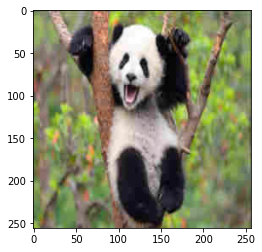

In [4]:
y_table, c_table = create_default_qtables()
JPEGCompress = DiffJPEG(image.shape[1], image.shape[2], differentiable=True, quality=15)
compressed_image = JPEGCompress(image.unsqueeze(0), y_table, c_table)[0]
plt.imshow(transforms.ToPILImage()(compressed_image))

In [5]:
with torch.no_grad():
    predictions = resnet(norm(image).unsqueeze(0))
    (target_class, target_dim) = return_class_name(id_classname_json, predictions)
    print(target_class)
    acc_of_original = return_class_accuracy(predictions, target_dim)
    
    predictions = resnet(norm(compressed_image).unsqueeze(0))
    acc_of_compressed = return_class_accuracy(predictions, target_dim)
    print(acc_of_original, acc_of_compressed)
    # predictied_class = return_class_name(predictions)[0]

giant_panda
65.0 52.0


In [13]:
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """

    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })

DatasetWIdx = dataset_with_indices(torchvision.datasets.ImageFolder)
train_dataset = DatasetWIdx("../../data/imagenette2/train", transform = preprocess)

# train_dataset = torchvision.datasets.ImageFolder("../../data/imagenette2/train", transform = preprocess)
train_dataset.class_to_idx = {
 'n01440764': 0,
 'n02102040': 217,
 'n02979186': 482,
 'n03000684': 491,
 'n03028079': 497,
 'n03394916': 566,
 'n03417042': 569,
 'n03425413': 571,
 'n03445777': 574,
 'n03888257': 701}
train_dataset.samples = train_dataset.make_dataset(train_dataset.root, 
                                                   train_dataset.class_to_idx, 
                                                   train_dataset.extensions, 
                                                   None)


# val_dataset = torchvision.datasets.ImageFolder("../../data/imagenette2/train", transform = preprocess)
# val_dataset.class_to_idx = {
#  'n01440764': 0,
#  'n02102040': 217,
#  'n02979186': 482,
#  'n03000684': 491,
#  'n03028079': 497,
#  'n03394916': 566,
#  'n03417042': 569,
#  'n03425413': 571,
#  'n03445777': 574,
#  'n03888257': 701}
# val_dataset.samples = val_dataset.make_dataset(val_dataset.root, 
#                                                val_dataset.class_to_idx, 
#                                                val_dataset.extensions, 
#                                                None)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 256)
# val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=16)

70

In [14]:
# pred = resnet(dataset[i][0].unsqueeze(0))
# idx = 9000
# print(return_class_name(resnet(dataset[idx][0].expand(3,-1,-1).unsqueeze(0))), dataset[idx][1])
# [print(return_class_name(resnet(i[0].expand(3,-1,-1).unsqueeze(0))), j) for i, j in dataset]

In [15]:
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor))
c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor))

In [16]:
y_table.shape

torch.Size([8, 8])

In [17]:
gumbel_softmax(y_table_1hot*10, 0.1, True).argmax(dim=2)

tensor([[ 18,   1,   1,   2,   1,   1, 126, 126],
        [  1,  16,  20,  27,  23,   8, 126, 126],
        [  7,  29,  27,  28,  27,  31, 126, 126],
        [  1,  32,  31,  25,  23,  25, 126, 126],
        [ 95,  34,  25,  25, 126, 126, 126, 126],
        [126,   1,  36, 126, 126, 126, 126, 126],
        [126, 126, 126, 126, 126, 126, 126, 126],
        [126, 126, 126, 126, 126, 126, 126, 126]])

## Calculate performance with default Q-Tables

In [25]:
y_table, c_table = create_default_qtables()
# y_table = torch.ones((8,8))
# c_table = torch.ones((8,8))
train_acc = 0

for (image, labels, idx) in tqdm(train_loader):
    with torch.no_grad():
        compressed_image = JPEGCompress(image, y_table, c_table)
        logits = resnet(norm(compressed_image))
        logits_uncompressed[idx] = logits
        (target_class, target_dim) = return_class_name(id_classname_json, logits[-1].unsqueeze(0))
        acc = return_class_accuracy(logits[-1].unsqueeze(0), target_dim)
        train_acc = train_acc + (logits.argmax(dim=1) == labels).sum()

print("Accuracy with default Q-Table:", train_acc/len(train_dataset))

100%|██████████| 1/1 [00:05<00:00,  5.79s/it]

Accuracy with default Q-Table: tensor(0.6857)


In [26]:
logits_uncompressed

tensor([[15.9666,  4.0804,  0.2450,  ...,  6.3768,  3.2473, -4.1550],
        [16.6012,  4.6676,  1.6385,  ...,  4.4325,  2.7529, -2.2399],
        [12.2811,  5.2065,  2.0069,  ...,  3.7868,  2.8018, -3.5596],
        ...,
        [-1.3702,  3.4876,  1.9374,  ..., -3.9931, -0.1909, -1.9916],
        [ 0.5758, -1.2132,  2.8975,  ..., -2.9081,  0.5633, -0.3296],
        [-0.5543, -0.5608,  2.0455,  ..., -3.9645,  0.6352,  0.1459]])

## Perturbing the Q-Tables to get better results

In [27]:
max_q_value = 128

y_table, c_table = create_default_qtables()
# y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
# c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
y_table_1hot = torch.nn.functional.one_hot(torch.ones((8,8), dtype=torch.LongTensor.dtype), 
                                           num_classes=max_q_value-1).type(torch.FloatTensor)
c_table_1hot = torch.nn.functional.one_hot(torch.ones((8,8), dtype=torch.LongTensor.dtype), 
                                           num_classes=max_q_value-1).type(torch.FloatTensor) 

y_table_1hot.requires_grad = True
c_table_1hot.requires_grad = True

optimizer = torch.optim.NAdam([
    y_table_1hot, 
    c_table_1hot
], lr=0.1)

ones_table = torch.ones((8,8))
ones_table.requires_grad = False

categorical_values_table = torch.arange(max_q_value-1).reshape(1,-1) + 1 
# + 1 to avoid divide by zero errors when quantizing
categorical_values_table.requires_grad = False

# print(y_table.requires_grad)

loss = torch.nn.MSELoss()
qloss = torch.nn.MSELoss(reduction='mean')

# sanity check to ensure that gradients are flowing and changing the 1 hot y_table 
best_y_1hot = deepcopy(y_table_1hot) 

best_y_table = deepcopy(y_table)
best_c_table = deepcopy(c_table)
best_loss = np.inf

ori_train_acc = 0.0

initial_temperature = 0.5
temperature_anneal_rate = 0.05

# Hyperparam alpha to balance between maximizing Quantization and 
# minimizing euclidean dist against uncompressed logits
alpha = torch.tensor((1e-5)) 
alpha.requires_grad=True

logits_uncompressed = torch.zeros((len(train_dataset), resnet.fc.out_features))
for (image, labels, idx) in tqdm(train_loader):
    with torch.no_grad():
        ori_logits = resnet(norm(image))
        logits_uncompressed[idx] = ori_logits
        (target_class, target_dim) = return_class_name(id_classname_json, ori_logits[-1].unsqueeze(0))
        original_acc = return_class_accuracy(ori_logits[-1].unsqueeze(0), target_dim)
        ori_train_acc = ori_train_acc + (ori_logits.argmax(dim=1) == labels).sum()
ori_train_acc = ori_train_acc / len(train_dataset)        


for epoch in range(100):
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0
    
    temperature = max(0.001, initial_temperature*np.exp(-temperature_anneal_rate*epoch))
    
    for (image, labels, idx) in tqdm(train_loader):                
        
        # y_table = gumbel_softmax(y_table_1hot.view(1, -1, 255), temperature, True) * categorical_values_table
        # c_table = gumbel_softmax(c_table_1hot.view(1, -1, 255), temperature, True) * categorical_values_table
        
        y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, max_q_value-1)/temperature, dim=2) * categorical_values_table
        c_table = torch.nn.functional.softmax(c_table_1hot.view(1, -1, max_q_value-1)/temperature, dim=2) * categorical_values_table
        
        y_table = y_table.sum(dim=2).reshape(8,8)
        c_table = c_table.sum(dim=2).reshape(8,8)

        # print(y_table)
        
        compressed_image = JPEGCompress(image, y_table, c_table)
        data = norm(compressed_image)
        logits = resnet(data)
        pred = logits.argmax(dim=1)
        
        ori_logits = logits_uncompressed[idx]
        
        loss_minimize = loss(logits, ori_logits) #we try to minimize this loss
        loss_maximize = (- qloss(y_table, ones_table) - qloss(c_table, ones_table))
        total_loss = (1-alpha)*loss_minimize + (alpha)* loss_maximize #total loss to be optimized

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # print((y_table_1hot == best_y_1hot).all())
        
        running_train_loss = running_train_loss + total_loss.detach().cpu() * image.shape[0]
        running_train_acc = running_train_acc + (pred == labels).sum()
            
    if running_train_loss/len(train_dataset) < best_loss:
        best_y_table = y_table
        best_c_table = c_table
        best_loss = running_train_loss/len(train_dataset)
        torch.save({"y_table" : y_table,
                   "c_table" : c_table,
                    "optimizer" : optimizer.state_dict(),
                   }, "best_ckpt.tar")
        
    if epoch % 10 == 0 and epoch > 0:
        torch.save({"y_table" : y_table,
           "c_table" : c_table,
            "optimizer" : optimizer.state_dict(),
           }, "epoch_{0}.tar".format(epoch))
        
    print("epoch {0}, training_loss: {1}, training_acc: {2}, ori_train_acc: {3}, logit loss: {4}, q table loss: {5}".format(
        epoch, 
        round(running_train_loss.item()/len(train_dataset), 5), 
        round(running_train_acc.item()/len(train_dataset)*100, 2),
        round(ori_train_acc.item()*100, 2),
        round(loss_minimize.item(), 5), 
        round(loss_maximize.item(), 5)
    ))
        

100%|██████████| 1/1 [00:11<00:00, 11.91s/it]


epoch 0, training_loss: 3.96544, training_acc: 21.43, ori_train_acc: 82.86, logit loss: 4.03755, q table loss: -7207.28027


100%|██████████| 1/1 [00:10<00:00, 10.68s/it]


epoch 1, training_loss: 3.75002, training_acc: 28.57, ori_train_acc: 82.86, logit loss: 3.83315, q table loss: -8308.7207


100%|██████████| 1/1 [00:10<00:00, 10.50s/it]


epoch 2, training_loss: 3.66566, training_acc: 24.29, ori_train_acc: 82.86, logit loss: 3.75806, q table loss: -9236.54492


100%|██████████| 1/1 [00:10<00:00, 10.51s/it]


epoch 3, training_loss: 3.50023, training_acc: 32.86, ori_train_acc: 82.86, logit loss: 3.60354, q table loss: -10327.34473


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [87]:
temperature

0.0035417044645260592

In [89]:
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 127)/temperature, dim=2) * categorical_values_table
c_table = torch.nn.functional.softmax(c_table_1hot.view(1, -1, 127)/temperature, dim=2) * categorical_values_table

y_table = y_table.sum(dim=2).reshape(8,8)
c_table = c_table.sum(dim=2).reshape(8,8)


print("y_table\n", y_table)
print("c_table\n", c_table)

tensor([[  2.,   2.,   2.,   2.,   2.,   1., 127., 127.],
        [ 15.,  19.,  28.,  26.,  38.,   8., 127., 127.],
        [ 10.,  42.,  46.,  30.,  31.,  42.,  17., 127.],
        [ 66.,  36.,  31.,  39.,  48., 127., 127., 127.],
        [127.,  32., 127., 127., 127., 127., 127., 127.],
        [127., 127., 127., 127., 127., 127., 127., 127.],
        [127., 127., 127., 127., 127., 127., 127., 127.],
        [127., 127., 127., 127., 127., 127., 127., 127.]],
       grad_fn=<ReshapeAliasBackward0>)

In [90]:
# Calculate accuracy if y_table and c_table were integers
y_table = y_table_1hot.argmax(dim=2)+1
c_table = c_table_1hot.argmax(dim=2)+1

train_acc = 0
for (image, labels) in tqdm(train_loader):
    with torch.no_grad():
        compressed_image = JPEGCompress(image, y_table, c_table)
        logits = resnet(norm(compressed_image))
        (target_class, target_dim) = return_class_name(id_classname_json, logits[-1].unsqueeze(0))
        acc = return_class_accuracy(logits[-1].unsqueeze(0), target_dim)
        train_acc = train_acc + (logits.argmax(dim=1) == labels).sum()

print(train_acc/len(train_dataset))

100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

tensor(0.6857)


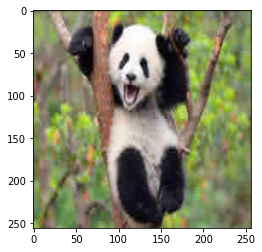

In [91]:
img = preprocess(Image.open("sample_imgs/panda.jpg"))
compressed_image = JPEGCompress(img.unsqueeze(0), y_table, c_table)[0]
# plt.figure(0, figsize=(20,20))
plt.imshow(transforms.ToPILImage()(compressed_image))

In [92]:
# check file size
import os
root = r"../../data/imagenette2/train2"
total_size_ori = 0

for folder in os.listdir(root):
    for file in os.listdir(os.path.join(root, folder)):
        total_size_ori += os.stat(os.path.join(root, folder, file)).st_size
        
print("total size originally:", total_size_ori)

qtable = {0: y_table.flatten().tolist(), 1: c_table.flatten().tolist()}
f_buffer = BytesIO()
total_size_aft = 0

for folder in os.listdir(root):
    for file in os.listdir(os.path.join(root, folder)):
        im.save(f_buffer, 'JPEG', qtables=qtable)
        total_size_aft += f_buffer.getbuffer().nbytes
        f_buffer.seek(0)
        f_buffer.truncate(0)

print("total size after:", total_size_aft)
print("compression_ratio:", round(total_size_aft/float(total_size_ori), 2))

total size originally: 6633823
total size after: 3967950
compression_ratio: 0.6


In [62]:
from io  import BytesIO
im = Image.open("sample_imgs/panda.jpg")
qtable = {0: y_table.flatten().tolist(), 1: c_table.flatten().tolist()}
# f_buffer = BytesIO()
im.save(f_buffer, 'JPEG', qtables=qtable)

In [55]:

im = Image.open("test.jpg")
print(np.array(im.quantization[0]).reshape(8,8), "\n", np.array(im.quantization[1]).reshape(8,8))

[[  2   1   2   2   1   1   2   2]
 [  2   2   2   2   2   2   2 255]
 [  2   2   2   2   2   2 255 255]
 [  2   2   2   2   2 255 255 255]
 [  2   2   2   2   2 255 255 255]
 [  2   2   2   2   2   2 255 255]
 [  2   2 255   2 255 255 255 255]
 [  2 255 255 255 255 255 255 255]] 
 [[  2   2   2 255 255 255 255 255]
 [  2   2   2 255 255 255 255 255]
 [  2   2 255 255 255 255 255 255]
 [  2 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]]


In [58]:
import os
print(os.stat('sample_imgs/panda.jpg').st_size, os.stat('test.jpg').st_size)

69691 119052


## Section for debugging

In [23]:
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255)/0.01, dim=2) * categorical_values_table
y_table = y_table.sum(dim=2).reshape(8,8)
y_table.type(torch.LongTensor)

tensor([[2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2]])

In [123]:
y_table, c_table = create_default_qtables()
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255)*10.0, dim=2) * categorical_values_table
        
y_table = y_table.sum(dim=2).reshape(8,8)
y_table

tensor([[ 17.2818,  13.3276,  15.3047,  15.3047,  19.2589,  25.1903,  49.9041,
          72.6409],
        [ 12.3391,  13.3276,  14.3162,  18.2704,  23.2132,  36.0644,  64.7325,
          92.4120],
        [ 11.3505,  15.3047,  17.2818,  23.2132,  38.0415,  55.8355,  78.5722,
          95.3777],
        [ 17.2818,  20.2475,  25.1903,  30.1330,  56.8240,  64.7325,  87.4692,
          98.3433],
        [ 25.1903,  27.1674,  41.0071,  51.8812,  68.6867,  81.5379, 103.2861,
         112.1831],
        [ 41.0071,  58.8011,  57.8126,  87.4692, 109.2174, 104.2747, 121.0801,
         100.3204],
        [ 51.8812,  60.7782,  69.6752,  80.5493, 103.2861, 113.1716, 120.0915,
         103.2861],
        [ 61.7668,  55.8355,  56.8240,  62.7553,  77.5836,  92.4120, 101.3090,
          99.3319]])

In [88]:
gumbel_softmax(y_table_1hot.view(1, -1, 255)*10.0, temperature, True).argmax(dim=2)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72,  11,  12,  13,  17,  22,  35,
          64,  92,  10,  14,  16,  22,  37,  55,  78,  95,  16,  19,  24,  29,
          56,  64,  87,  98,  24,  26,  40,  51,  68,  81, 103, 112,  40,  58,
          57,  87, 109, 104, 121, 100,  51,  60,  69,  80, 103, 113, 120, 103,
          61,  55,  56,  62,  77,  92, 101,  99]])

In [24]:
y_table = gumbel_softmax(y_table_1hot.view(1, -1, 255), 0.01, True) * categorical_values_table
y_table = y_table.sum(dim=2).reshape(8,8)
y_table

tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.]], grad_fn=<ReshapeAliasBackward0>)

In [29]:
y_table, c_table = create_default_qtables()
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor), num_classes=255).type(torch.FloatTensor) * 5
c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor), num_classes=255).type(torch.FloatTensor) * 5

In [29]:
y_table_1hot.view(-1,255)

torch.Size([64, 255])

In [36]:
gumbel_softmax(y_table_1hot.view(1, -1, 255)*5, 0.1, True).argmax(dim=2).reshape(8,8)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72],
        [ 11,  12,  13,  17,  22,  35,  64,  92],
        [ 10,  14,  16,  22,  37,  55,  78,  95],
        [ 16,  19,  24,  29,  56,  64,  87,  98],
        [ 24,  26,  40,  51,  68,  81, 103, 112],
        [ 40,  58,  57,  87, 109, 104, 121, 100],
        [ 51,  60,  69,  80, 103, 113, 120, 103],
        [ 61,  55,  56,  62,  77,  92, 101,  99]])

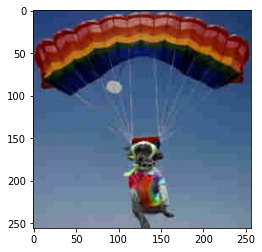

In [38]:
compressed = JPEGCompress(image, torch.round(y_table), torch.round(c_table))[1]
plt.imshow(transforms.ToPILImage()(compressed))

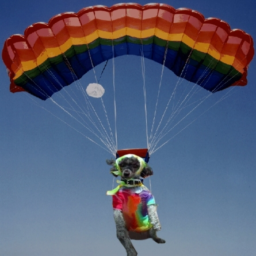

In [36]:
transforms.ToPILImage()(image[1])

In [39]:
torch.save({"y_table" : y_table,
           "c_table" : c_table,
            "optimizer" : optimizer.state_dict(),
           }, "best_ckpt.tar")

In [28]:
t = torch.load("best_ckpt.tar")
t

{'y_table': tensor([[ 18.7794,   1.0391,   1.0958,   3.2082,   1.0206,   1.0086, 126.9421,
          126.9475],
         [  1.0153,  10.4550,  14.5959,  17.1053,  16.4002,   8.8994, 126.9578,
          126.9546],
         [  4.7323,  16.2672,  20.3360,  18.9857,  20.9559,  25.3670, 126.9551,
          126.9534],
         [  1.0467,  20.4178,  22.5487,  19.3475,  20.2991, 126.9566, 126.9536,
          126.9517],
         [120.8537,  23.6335,  21.4882,  22.5561, 126.9586, 126.9551, 126.9532,
          126.9521],
         [126.9308, 119.6029,  32.1649, 126.9546, 126.9565, 126.9532, 126.9523,
          126.9519],
         [126.9546, 126.9564, 126.9554, 126.9546, 126.9512, 126.9524, 126.9518,
          126.9519],
         [126.9517, 126.9532, 126.9524, 126.9534, 126.9519, 126.9522, 126.9520,
          126.9518]], requires_grad=True),
 'c_table': tensor([[ 17.2569,  27.6071,  24.8947, 126.9550, 126.9523, 126.9514, 126.9516,
          126.9518],
         [ 36.9890,  24.7326,  20.9849, 126.953